In [26]:
# ms-python.python added
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import seaborn as sns
sns.set()
%matplotlib inline
sns.set()

In [2]:
cd /mnt/sda/otani/Experiments/moment_retrieval/

/mnt/sda/otani/Experiments/moment_retrieval


# Query-based temporal proposal generation

Input: description

Output: \mu and \sigma of starting point and duration

In [152]:
import chainer
import chainer.links as L
import chainer.functions as F
import chainer.distributions as D
from chainer import reporter

class MultivariateEncoder(chainer.Chain):
    def __init__(self):
        super(MultivariateEncoder, self).__init__()
        with self.init_scope():
            self.mu = L.Linear(None, 2)
            self.scale = L.Linear(None, 4)
    
    def __call__(self, h):
        mu = self.mu(h)
        scale = self.scale(h)
        scale = F.reshape(scale, (-1,2,2))
         
        d = D.Independent(D.MultivariateNormal(loc=mu, scale_tril=scale))
        return d

In [153]:
import chainer
import chainer.links as L
import chainer.functions as F
import chainer.distributions as D
from chainer import reporter

class TemporalProposalNet(chainer.Chain):
    def __init__(self, query_net, encoder, k=1):
        super(TemporalProposalNet, self).__init__()
        
        self.k = k
        
        with self.init_scope():
            self.query_net = query_net
            self.encoder = encoder
            
    def sample(self, x, n):
        h = self.query_net(x)
        d = self.encoder(h)
        y = d.sample_n(n)
        prob = d.prob(y)
        return y, prob
    
    def __call__(self, x, y):
        h = self.query_net(x)
        d = self.encoder(h)
        reconstr = F.mean(
            d.log_prob(
                F.broadcast_to(y, (self.k,)+y.shape)
            )
        )
        
        loss = -reconstr
        reporter.report({'loss': loss}, self)
        
        return loss
        
class QueryEmbedNet(chainer.Chain):
    def __init__(self, n_vocab, n_latent=100):
        super(QueryEmbedNet, self).__init__()
        with self.init_scope():
            self.emb = L.EmbedID(n_vocab, n_latent)
            self.lstm = L.NStepLSTM(1, n_latent, n_latent, dropout=0.)
    
    def __call__(self, x):
        emb = [self.emb(i) for i in x]
        hy, _, _ = self.lstm(None, None, emb)
        hy = F.squeeze(hy)
        return hy

class Encoder(chainer.Chain):
    def __init__(self):
        super(Encoder, self).__init__()
        with self.init_scope():
            self.mu = L.Linear(None, 2)
            self.sigma = L.Linear(None, 2)
    
    def __call__(self, h):
        mu = self.mu(h)
        ln_sigma = self.sigma(h)
         
        d = D.Independent(D.Normal(loc=mu, log_scale=ln_sigma))
        return d

# DataLoader

- word indices
- normalized starting point
- normalized duration

In [154]:
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_punctuation, stem_text, strip_multiple_whitespaces
from chainer.dataset import DatasetMixin
from chainer.dataset.convert import to_device

def load_dataset_file(df_file):
    df = pd.read_csv(df_file)
    indices = np.where(df['end (sec)'] - df['start (sec)'] < 0)
    df = df.drop(index=indices[0])
    df['start (norm)'] = df['start (sec)']/df['length']
    df['end (norm)'] = df['end (sec)']/df['length']
    df['moment duration (norm)'] = df['end (norm)'] - df['start (norm)']
    return df

def preprocess_desc(desc):
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation, strip_multiple_whitespaces, stem_text]
    desc = [preprocess_string(s, CUSTOM_FILTERS) for s in desc]
    return desc

def save_dict(df_file, out_file):
    df = load_dataset_file(df_file)
    desc = preprocess_desc(df['description'])
    dictionary = Dictionary(desc)
    dictionary.compactify()
    dictionary.save_as_text(out_file)

class DataLoader(DatasetMixin):
    
    def __init__(self, df_file, dictionary_file, san_check=False):
        # load dictionary
        self.dictionary = Dictionary.load_from_text(dictionary_file)
        
        df = load_dataset_file(df_file)
        
        if san_check:
            df = df[:500]
        
        # preprocessing
        self._df = df
        self.desc = preprocess_desc(df['description'])
        self.start = df['start (norm)'].values
        self.duration = df['moment duration (norm)'].values
        
    def __len__(self):
        return len(self.desc)
        
    def get_example(self, i):
        strt = self.start[i]
        dur = self.duration[i]
        desc = self.desc[i]
        desc_i = self.dictionary.doc2idx(desc)
        return desc_i, (strt, dur)

def cvrt_f(batch, device=None):
    x = [to_device(device, np.asarray(b[0]).astype('i')) for b in batch]
    y1 = np.asarray([b[1] for b in batch]).astype('f')
    y1 = to_device(device, y1)
    return x, y1

# Train

In [155]:
from chainer.iterators import SerialIterator
from chainer import training
from chainer.optimizers import Adam
from chainer.datasets import split_dataset_random
from chainer.training import extensions
from chainer.optimizer_hooks import WeightDecay, GradientClipping
def train():
    b_size = 100
    epoch = 15
    saveto = 'models/blind/'
    device = 0

    device = chainer.get_device(device)

    dict_file = 'data/processed/dictionary.txt'
    data = DataLoader('data/processed/train.csv',
                      dict_file,
                     san_check=False)
    train, val = split_dataset_random(data, int(len(data)*.8))
    train_iter = SerialIterator(train, b_size)
    val_iter = SerialIterator(val, b_size, repeat=False, shuffle=False)

    query_net = QueryEmbedNet(len(data.dictionary))
    encoder = Encoder()
    model = TemporalProposalNet(query_net, encoder)
    model.to_device(device)
    device.use()

    opt = Adam()
    opt.setup(model)
    opt.add_hook(WeightDecay(0.0001))
    opt.add_hook(GradientClipping(5))

    updater = training.StandardUpdater(train_iter, opt, converter=cvrt_f, device=device)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=saveto)

    trainer.extend(extensions.Evaluator(val_iter, model, converter=cvrt_f, device=device))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss']))

    trainer.run()
    return model

# Evaluation

In [156]:
def non_maximum_suppression(bbox, thresh, score=None, limit=None):
    if len(bbox) == 0:
        return np.zeros((0,), dtype=np.int32)

    if score is not None:
        order = score.argsort()[::-1]
        bbox = bbox[order]
    bbox_area = bbox[:, 1] - bbox[:, 0]

    selec = np.zeros(bbox.shape[0], dtype=bool)
    
    for i, b in enumerate(bbox):
        if not bbox_area[i] > 0:
            continue
            
        if not selec.any():
            selec[i] = True
            continue
            
        st = np.maximum(b[0], bbox[selec, 0])
        ed = np.minimum(b[1], bbox[selec, 1])
        area = (ed - st) * (st < ed)
            
        iou = area / (bbox_area[i] + bbox_area[selec] - area)
        
        # when the temporal bbox highly overlap with any of selected bbox
        if (iou >= thresh).any(): 
            continue

        selec[i] = True
        if limit is not None and np.count_nonzero(selec) >= limit:
            break
    
    selec = np.where(selec)[0]
    if score is not None:
        selec = order[selec]
    return selec.astype(np.int32)

JSON_ROOT = './data/interim/object_detection/charade/'

def get_object_motions(video_id, start_time, end_time):
    detec = json.load(open(JSON_ROOT+video_id+'.json'))
    start_fr = int(np.ceil(4 * start_time))
    end_fr = int(np.ceil(4 * end_time))
    n_fr = end_fr - start_fr
    
    if n_fr < 1:
        return None
    
    non_background_area = 0
    motions = []
    for i in range(start_fr, end_fr):
        try:
            cur_objs = detec[i]
        except IndexError:
            continue
        
        if len(cur_objs) == 0:
            motions.append([0]) # motion 0 when no objects detected
            continue
        
        try:
            prev_objs = detec[i-1]
        except IndexError:
            motions.append([0])
            continue
        
        m_vals = [] # motions for each object
        for item in cur_objs:
            label = item['label']
            bbox = item['bbox']
            c_y = (bbox[2] + bbox[0]) / 2
            c_x = (bbox[3] + bbox[1]) / 2
            
            m_val = np.inf
            for p_item in prev_objs:
                
                if p_item['label'] != label:
                    continue
                    
                p_bbox = p_item['bbox']
                p_y = (p_bbox[2] + p_bbox[0]) / 2
                p_x = (p_bbox[3] + p_bbox[1]) / 2

                dist = (c_x - p_x)**2 + (c_y - p_y)**2
                dist = np.sqrt(dist)
                if dist < m_val: # select closed object as match
                    m_val = dist
            
            if m_val == np.inf: # if object newly appear at this frame
                m_val = 0
                
            m_vals.append(m_val)
            
        motions.append(m_vals)
    return motions

def get_object_motion_based_score(video_id, start_time, end_time):
    motions = get_object_motions(video_id, start_time, end_time)
    if motions is None:
        return 0
    motions = [sum(m) for m in motions]
    score = max(motions)
    return score

def iou(pred_s, pred_e, true_s, true_e):
    assert true_s < true_e, "true value invalid: (%.2f, %.2f)"%(true_s, true_e)
    if pred_s > pred_e:
        print("predicted value invalid: (%.2f, %.2f)"%(pred_s, pred_e))
        return 0

    union = min(pred_s, true_s), max(pred_e, true_e)
    intersection = max(pred_s, true_s), min(pred_e, true_e)

    if intersection[0] > intersection[1]:
        return 0

    iou_val = (intersection[1] - intersection[0]) / (union[1] - union[0])
    return iou_val

In [157]:
def eval_model(model, device):
    test = DataLoader('data/processed/test.csv',
                      'data/processed/dictionary.txt',
                      san_check=False)

    test_iter = SerialIterator(test, 100, repeat=False, shuffle=False)
    
    results = {
        'R@1 IoU>.5': [],
        'R@1 IoU>.7': [],
        'R@5 IoU>.5': [],
        'R@5 IoU>.7': [],
    }

    iou_arr = []

    j = 0

    for batch in test_iter:
        N = len(batch)
        x, y = cvrt_f(batch, device)

        with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
            preds, probs = model.sample(x, 100)

        y = chainer.cuda.to_cpu(y)
        preds.to_cpu()
        preds = preds.data
        probs.to_cpu()
        probs = np.squeeze(probs.data)

        for i in range(N):
            video_id = test._df['id'][j+i]
            length = test._df['length'][j+i]

            pred = preds[:, i, :]

            # format prediction
            start_t = pred[:, 0]
            duration = pred[:, 1]
            start_t = np.clip(start_t, 0, 1)
            duration = np.clip(duration, 0, 1)
            end_t = np.clip(start_t + duration, 0, 1)

            # estimated start and end point in sec
            start_sec = start_t * length
            end_sec = end_t * length

            # compute object based score
            prob = probs[:, i] # likelifood of temporal proposals
            scores = [get_object_motion_based_score(video_id, s, e) for s, e in zip(start_sec, end_sec)]
            scores *= prob

            # non maximum supression for temporal proposals
            bbox = np.hstack([start_t[:, None], end_t[:, None]])

            selected = np.zeros((1,))
            thresh = .5
            while(selected.size < 5):
                selected = non_maximum_suppression(bbox, thresh, scores)
                thresh += 0.2

            # eval iou
            gt_s, gt_d = y[i]
            gt_e = gt_s + gt_d

            start_t = start_t[selected][:5]
            end_t = end_t[selected][:5]

            ious = [iou(s, e, gt_s, gt_e) for s, e in zip(start_t, end_t)]
            iou_arr.append(ious)

        j += N
    
    iou_arr = np.asarray(iou_arr)
    top_1 = iou_arr[:, 0]
    results['R@1 IoU>.5'].append((top_1 > 0.5).mean()*100)
    results['R@1 IoU>.7'].append((top_1 > 0.7).mean()*100)
    results['R@5 IoU>.5'].append((np.max(iou_arr, axis=1) > 0.5).mean()*100)
    results['R@5 IoU>.7'].append((np.max(iou_arr, axis=1) > 0.7).mean()*100)
    return results

In [158]:
records = []
for _ in range(10):
    model = train()
    res = eval_model(model, device=0)
    records.append(res)

epoch       main/loss   validation/main/loss
1           -0.220048   -0.705625             
2           -0.770655   -0.792991             
3           -0.846928   -0.828141             
4           -0.909675   -0.813263             
5           -0.940729   -0.823328             
6           -0.966811   -0.859249             
7           -0.993187   -0.83235              
8           -1.01919    -0.854467             
9           -1.03873    -0.862851             
10          -1.05768    -0.818663             
11          -1.07933    -0.814286             
12          -1.0994     -0.741518             
13          -1.12676    -0.749227             
14          -1.14987    -0.754362             
15          -1.17368    -0.643456             
epoch       main/loss   validation/main/loss
1           -0.164526   -0.658673             
2           -0.742772   -0.742365             
3           -0.851103   -0.798816             
4           -0.919319   -0.796276             
5           -0.96

In [159]:
from collections import defaultdict

summary = defaultdict(list)
for r in records:
    for k, v in r.items():
        summary[k].append(v[0])


for k, v in summary.items():
    print(k, '{:.2f} ({:.2f})'.format(np.mean(v), np.std(v)))

R@1 IoU>.5 25.33 (1.12)
R@1 IoU>.7 10.38 (0.71)
R@5 IoU>.5 73.94 (1.23)
R@5 IoU>.7 41.56 (1.61)


# Object detection examples

- SSD with VGG16 backbone
- Trained on PASCAL VOC

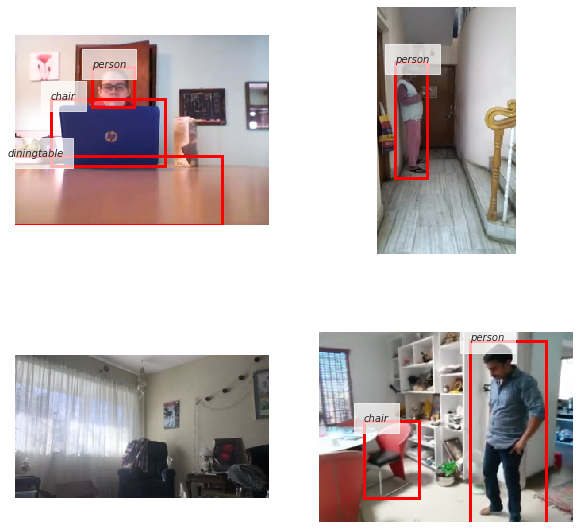

In [12]:
from chainercv.visualizations import vis_bbox
from chainercv.datasets import voc_bbox_label_names
from imageio import imread

f, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax in axes.ravel():
    v_id = test._df.id.sample().values[0]
    jsn = json.load(open(JSON_ROOT+'%s.json'%v_id))

    i = np.random.randint(len(jsn))

    # dataset frames are sampled at 24 fps
    # object detection is done at 4 fps
    im = imread('/home/otani_mayu/3TDisk/Data/Charades/Charades_v1_rgb/%s/%s-%06i.jpg'%(v_id, v_id, i*6))

    item = jsn[i]
    bbox = [x['bbox'] for x in item]
    label = [x['label'] for x in item]
    vis_bbox(im.transpose(2,0,1),
            bbox,
            label,
            label_names=voc_bbox_label_names,
            ax=ax)

    ax.axis('off')

 # Baselines

 ## Random (sliding window)

 Random baseline method in prior work

 This method generate temporal proposals with multi-scale temporal sliding window: {64, 128, 256, 512} frames and 80% overlap

 Moments are randomly sampled from the generated proposals

 ## Random (KDE)

 The distribution of moments' start time and duration is estimated with KDE
 
 During testing, this method sample proposals from the estimated distribution and rank them in the order of the values of probability density function
 
 ## Query-aware baseline
 
 Learn the distribution of moments' start time and duration conditioned on query description.
 
 The temporal proposals are sampled from the estimated distribution.
 
 Note that this baseline does not use input videos at all.
 
 ## Object-based scoring
 
 Detect objects in frames and compute the size of object bounding boxes.
 
 I take the average size of object areas over frames as the moment's score.
 
 Therefore, the score discourage background frames.


 ## Results

 | method                             | R@1 IoU=0.5 | R@1 IoU=0.7 | R@5 IoU=0.5 | R@5 IoU=0.7 |
 |------------------------------------|------------:|------------:|------------:|------------:|
 | Random (sliding window)            |        8.51 |        3.03 |       37.12 |       14.06 |
 | Random (KDE)                       |       20.72 |        8.05 |       58.08 |       26.84 |
 | Query-aware                        |       24.09 |        8.63 |       34.78 |       17.66 |
 | Object-based scoring               |       26.04 |       10.64 |       56.90 |       34.16 |
 | CTRL (ICCV'17)                     |       21.42 |        7.15 |       59.11 |       26.91 |
 | Xu et al. (AAAI'19)                |       35.60 |       15.80 |       79.40 |       45.40 |
 | MAN (CVPR'19)                      |       46.53 |       22.72 |       86.23 |       53.72 |

# analysis on object motions

In [88]:
test = load_dataset_file('data/processed/test.csv')
pos_mean = []
pos_max = []
neg_mean = []
neg_max = []

for i, row in test.iterrows():
    video_id = row['id']
    start_time = row['start (sec)']
    end_time = row['end (sec)']
    length = row['length']
    motions = get_object_motions(video_id, start_time, end_time)
    motions = [sum(m) for m in motions]
    
    dur = end_time - start_time
    
    if np.random.random() > .5:
        n_start = end_time + np.random.random()*length
        n_start = min(n_start, length - dur)
    else:
        n_start = start_time - dur - np.random.random()*length
        n_start = max(n_start, 0)
    
    n_end = n_start + dur
        
    n_motions = get_object_motions(video_id, n_start, n_end)
    n_motions = [sum(m) for m in n_motions]
    
    pos_mean.append(np.mean(motions))
    pos_max.append(np.max(motions))
    neg_mean.append(np.mean(n_motions))
    neg_max.append(np.max(n_motions))
    
    

(array([575., 819., 676., 529., 352., 230., 192., 119.,  73.,  38.,  36.,
         17.,  14.,  11.,  16.,   4.,   7.,   3.,   1.,   4.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 0.        ,  2.48353647,  4.96707293,  7.4506094 ,  9.93414586,
        12.41768233, 14.90121879, 17.38475526, 19.86829173, 22.35182819,
        24.83536466, 27.31890112, 29.80243759, 32.28597405, 34.76951052,
        37.25304698, 39.73658345, 42.22011992, 44.70365638, 47.18719285,
        49.67072931, 52.15426578, 54.63780224, 57.12133871, 59.60487518,
        62.08841164, 64.57194811, 67.05548457, 69.53902104, 72.0225575 ,
        74.50609397]),
 <a list of 30 Patch objects>)

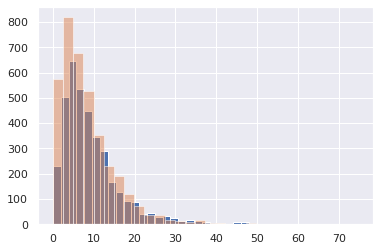

In [89]:
plt.hist(pos_mean, bins=30)
plt.hist(neg_mean, bins=30, alpha=.5)

(array([618., 701., 571., 361., 265., 216., 144., 122., 132.,  89.,  93.,
         70.,  67.,  58.,  46.,  37.,  20.,  22.,  21.,  24.,  11.,   8.,
          5.,   4.,   0.,   3.,   5.,   5.,   1.,   1.]),
 array([  0.        ,  10.82141613,  21.64283225,  32.46424838,
         43.28566451,  54.10708064,  64.92849676,  75.74991289,
         86.57132902,  97.39274514, 108.21416127, 119.0355774 ,
        129.85699353, 140.67840965, 151.49982578, 162.32124191,
        173.14265803, 183.96407416, 194.78549029, 205.60690642,
        216.42832254, 227.24973867, 238.0711548 , 248.89257092,
        259.71398705, 270.53540318, 281.35681931, 292.17823543,
        302.99965156, 313.82106769, 324.64248381]),
 <a list of 30 Patch objects>)

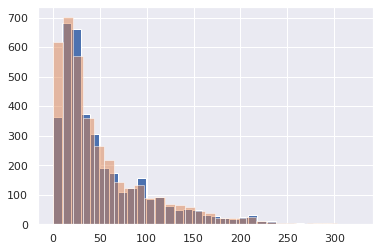

In [90]:
plt.hist(pos_max, bins=30)
plt.hist(neg_max, bins=30, alpha=.5)

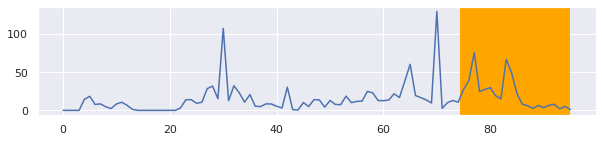

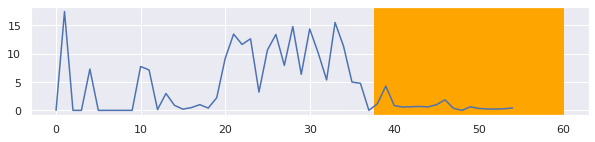

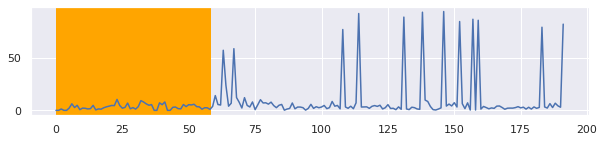

In [145]:
from skvideo.io import ffprobe

test = load_dataset_file('data/processed/test.csv')
for _ in range(3):
    
    row = test.sample()
    video_id = row['id'].values[0]
    start_time = row['start (sec)'].values[0]
    end_time = row['end (sec)'].values[0]
    length = row['length'].values[0]
    motions = get_object_motions(video_id, 0, length)
    motions = [sum(m) for m in motions]


    plt.figure(figsize=(10,2))
    plt.plot(motions)
    plt.axvspan(start_time*4, end_time*4, 0, max(motions)+20, color='orange')
    plt.show()
    
    vid_arr = vread('/home/otani_mayu/3TDisk/Data/Charades/Charades_v1_480/%s.mp4'%video_id,
                   outputdict={'-vf': 'fps=%i'%4})
    
    for i in range(int(start_time*4), int(enend_time*4)):
        vid_arr[i][:10, :, :] = [255, 0, 0]
        vid_arr[i][-10:, :, :] = [255, 0, 0]
        vid_arr[i][:, :10, :] = [255, 0, 0]
        vid_arr[i][:, -10:, :] = [255, 0, 0]

In [146]:
vid_arr.shape

(377, 270, 480, 3)

In [148]:
length * 4

191.52

287.28000000000003